In [170]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import time
import sklearn
from sklearn import *

In [171]:
sns.set(style = "dark")
%matplotlib inline

# 1. Dataset import and Cleansing

In [172]:
def toLower(x):
    return x.strip().lower()

In [173]:
trainDF = pd.read_csv("trainTraffic.csv")

In [174]:
trainDF["attack"] = trainDF['attack'].apply(toLower)
trainDF = trainDF.rename(columns = {"attack" : "attackType"})

In [175]:
print(trainDF.shape)
trainDF.head()

(125973, 43)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attackType,last_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [176]:
trainDF['attack'] = 1
trainDF.loc[(trainDF.attackType == 'normal'), 'attack'] = 0
pd.DataFrame(trainDF.groupby('attack').agg({'attack' : ['count']}))

,attack
,count
attack,
0,67343
1,58630


In [177]:
pd.DataFrame(trainDF.groupby("attackType").agg({'attackType':['count']}))

,attackType
,count
attackType,
back,956
buffer_overflow,30
ftp_write,8
guess_passwd,53
imap,11
ipsweep,3599
land,18
loadmodule,9


In [178]:
normal=['normal']
dos =['back','land','neptune','pod','smurf','teardrop','apache2',
      'udpstorm','processtable','worm(10)','mailbomb','worm']
probe =['satan','ipsweep','nmap','portsweep','mscan','sanit(6)','saint']
r2l =['guess_passwd','ftp_write','imap','phf','multihop','warezmaster',
      'warezclient','spy','xlock','xsnoop','snmpguess','snmpgetattack',
      'httptunnel','sendmail','named(16)','named']
u2r =['buffer_overflow','loadmodule','rootkit','perl','sqlattack','xterm','ps(7)','ps']

trainDF['attack_class'] = -1
trainDF.loc[(trainDF['attackType'].isin(normal)), 'attack_class'] = 0
trainDF.loc[(trainDF['attackType'].isin(dos)), 'attack_class'] = 1
trainDF.loc[(trainDF['attackType'].isin(probe)), 'attack_class'] = 2
trainDF.loc[(trainDF['attackType'].isin(r2l)), 'attack_class'] = 3
trainDF.loc[(trainDF['attackType'].isin(u2r)), 'attack_class'] = 4


pd.DataFrame(trainDF.groupby("attack_class").agg({"attack_class" : ['count']}))

,attack_class
,count
attack_class,
0,67343
1,45927
2,11656
3,995
4,52


In [179]:
attackSum = (sum(trainDF['attack'])/len(trainDF['attack'].index))*100
attackSum

46.54171925730117

In [180]:
chkNone = trainDF.loc[:, (trainDF.isnull().all())]
chkNone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Empty DataFrame

In [181]:
chkOneVal = trainDF.loc[:, (trainDF.nunique() == 1)]
chkOneVal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125973 entries, 0 to 125972
Data columns (total 1 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   num_outbound_cmds  125973 non-null  int64
dtypes: int64(1)
memory usage: 984.3 KB


In [182]:
trainDF = trainDF.drop(['num_outbound_cmds'], axis = 1)

# 2. Data PreProcessing

In [183]:
(round(100 * (trainDF.isnull().sum() / len(trainDF.index)) , 2)).sort_values(ascending = False)

attack_class                   0.0
attack                         0.0
is_host_login                  0.0
num_access_files               0.0
num_shells                     0.0
num_file_creations             0.0
num_root                       0.0
su_attempted                   0.0
root_shell                     0.0
num_compromised                0.0
logged_in                      0.0
num_failed_logins              0.0
hot                            0.0
urgent                         0.0
wrong_fragment                 0.0
land                           0.0
dst_bytes                      0.0
src_bytes                      0.0
flag                           0.0
service                        0.0
protocol_type                  0.0
is_guest_login                 0.0
count                          0.0
srv_count                      0.0
dst_host_diff_srv_rate         0.0
last_flag                      0.0
attackType                     0.0
dst_host_srv_rerror_rate       0.0
dst_host_rerror_rate

# 3. Data Analysis

In [184]:
trainDF['attack_display'] = 'normal'
trainDF.loc[trainDF['attack'] == 1, 'attack_display'] = 'attack'
trainDF.loc[trainDF['attack_class'] == 0, 'attack_class_display'] = 'normal'
trainDF.loc[trainDF['attack_class'] == 1, 'attack_class_display'] = 'dos'
trainDF.loc[trainDF['attack_class'] == 2, 'attack_class_display'] = 'probe'
trainDF.loc[trainDF['attack_class'] == 3, 'attack_class_display'] = 'r21'
trainDF.loc[trainDF['attack_class'] == 4, 'attack_class_display'] = 'u2r'

In [185]:
chkAttack = trainDF.loc[trainDF['attack'] == 1]
atkClass = pd.DataFrame(chkAttack.groupby('attack_class_display')['attack_class'].count())
atkClass['class'] = [x.upper() for x in atkClass.index]
atkClass['cnt'] = [str(x) for x in atkClass['attack_class']]

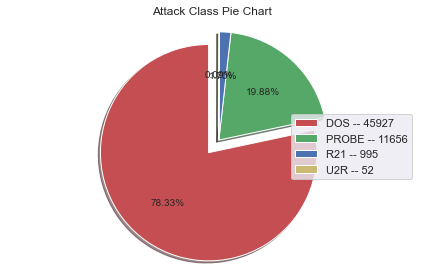

In [186]:
colors = ['r','g', 'b','y','c']

labels = atkClass['class'] + ' -- ' + atkClass['cnt']

plt.pie(
    atkClass.attack_class,
    shadow = True,
    colors = colors,
    autopct = '%1.2f%%',
    explode = (0.15,0,0,0),
    startangle = 90
)

plt.title('Attack Class Pie Chart')
plt.legend(labels, loc = 5)

plt.axis('equal')

plt.tight_layout()
plt.show()

In [187]:
corrM = pd.DataFrame(trainDF)
corr = corrM.corr()
corr

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag,attack,attack_class
duration,1.000000,0.070737,0.034878,-0.001553,-0.009866,0.003830,0.000705,0.009528,-0.064218,0.042679,...,0.254195,0.228737,-0.026669,-0.064948,-0.064361,0.173815,0.199024,-0.156311,0.048785,0.129443
src_bytes,0.070737,1.000000,0.000204,-0.000109,-0.000693,-0.000059,0.000295,-0.000208,-0.003353,-0.000086,...,0.000900,0.000431,-0.001655,-0.004503,-0.003397,-0.001468,0.012449,-0.022592,0.005921,0.012981
dst_bytes,0.034878,0.000204,1.000000,-0.000069,-0.000440,0.000248,-0.000344,0.000504,-0.002894,0.001233,...,0.011031,0.011747,-0.001281,-0.003024,-0.002944,0.011729,0.011223,-0.018076,0.004118,0.008651
land,-0.001553,-0.000109,-0.000069,1.000000,-0.001261,-0.000109,-0.001340,-0.000381,-0.011402,-0.000164,...,-0.004516,0.033851,0.070474,0.019840,0.012276,-0.005222,-0.005303,-0.037038,0.007191,0.002944
wrong_fragment,-0.009866,-0.000693,-0.000440,-0.001261,1.000000,-0.000692,-0.008508,-0.002418,-0.072418,-0.001044,...,0.059797,0.037177,-0.016252,-0.051917,-0.055917,0.028890,-0.033682,-0.157130,0.095905,0.054795
urgent,0.003830,-0.000059,0.000248,-0.000109,-0.000692,1.000000,0.000293,0.097507,0.007299,0.033329,...,0.006840,0.002741,0.005176,-0.004749,-0.004834,-0.002999,-0.002912,-0.016411,-0.002787,0.003941
hot,0.000705,0.000295,-0.000344,-0.001340,-0.008508,0.000293,1.000000,0.003715,0.116435,0.002014,...,-0.012293,-0.034536,-0.024715,-0.058222,-0.058214,-0.030555,-0.031670,-0.160013,-0.013083,0.065085
num_failed_logins,0.009528,-0.000208,0.000504,-0.000381,-0.002418,0.097507,0.003715,1.000000,-0.006439,0.019085,...,-0.001945,-0.005526,0.003302,-0.011648,-0.012299,0.018660,0.017359,-0.073178,-0.003755,0.023120
logged_in,-0.064218,-0.003353,-0.002894,-0.011402,-0.072418,0.007299,0.116435,-0.006439,1.000000,0.014413,...,-0.256065,-0.160994,-0.055953,-0.491478,-0.493264,-0.275972,-0.272806,0.269818,-0.690171,-0.576031
num_compromised,0.042679,-0.000086,0.001233,-0.000164,-0.001044,0.033329,0.002014,0.019085,0.014413,1.000000,...,0.002981,-0.002045,0.004252,-0.004377,-0.004898,-0.003647,-0.003219,-0.006101,-0.010198,-0.009003


In [188]:
corr_M = corrM.corr().abs()
upperrows = corr_M.where(np.triu(np.ones(corr_M.shape), k = 1).astype(np.bool))

highcorr = [column for column in upperrows.columns if any(upperrows[column] > 0.86)]

In [189]:
corrM = pd.DataFrame(trainDF[highcorr])
corr = corrM.corr()
corr

,num_root,is_guest_login,srv_serror_rate,srv_rerror_rate,dst_host_same_srv_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack_class
num_root,1.000000,-0.001208,-0.005675,-0.004001,-0.005918,-0.004803,-0.005282,-0.003827,-0.003497,-0.010020
is_guest_login,-0.001208,1.000000,-0.059795,-0.035249,-0.054297,-0.060743,-0.060483,-0.030712,-0.033083,0.030600
srv_serror_rate,-0.005675,-0.059795,1.000000,-0.234507,-0.619130,0.977596,0.986252,-0.235065,-0.233142,0.378669
srv_rerror_rate,-0.004001,-0.035249,-0.234507,1.000000,-0.255565,-0.226470,-0.230751,0.917822,0.970208,0.309909
dst_host_same_srv_rate,-0.005918,-0.054297,-0.619130,-0.255565,1.000000,-0.639205,-0.632048,-0.257178,-0.258147,-0.525829
dst_host_serror_rate,-0.004803,-0.060743,0.977596,-0.226470,-0.639205,1.000000,0.985052,-0.235535,-0.227914,0.382118
dst_host_srv_serror_rate,-0.005282,-0.060483,0.986252,-0.230751,-0.632048,0.985052,1.000000,-0.234508,-0.232917,0.384796
dst_host_rerror_rate,-0.003827,-0.030712,-0.235065,0.917822,-0.257178,-0.235535,-0.234508,1.000000,0.924688,0.293805
dst_host_srv_rerror_rate,-0.003497,-0.033083,-0.233142,0.970208,-0.258147,-0.227914,-0.232917,0.924688,1.000000,0.310227
attack_class,-0.010020,0.030600,0.378669,0.309909,-0.525829,0.382118,0.384796,0.293805,0.310227,1.000000


dst_host_serrror_rate is high correleated with srv_serror_rate

dst_host_srv_serror_rate is high correleated with srv_serror_rate

dst_host_rerror_rate is high correleated with srv_rerror_rate

dst_host_srv_rerror_rate is high correleated with srv_rerror_rate

In [190]:
trainDF_copy = trainDF
trainDF = trainDF.drop(['attackType', 'attack_class', 'attack_display', 'attack_class_display'],
                      axis = 1)
trainDF.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag,attack
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20,0
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21,0


In [191]:
trainDF = pd.get_dummies(trainDF)

In [192]:
trainDF.shape

(125973, 123)

In [193]:
atk = (sum(trainDF['attack']) / len(trainDF['attack'].index)) * 100
atk

46.54171925730117

# Binomial Classification

In [194]:
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier

In [195]:
x = trainDF.drop(['attack'], axis = 1)
y = trainDF['attack']
x_Train, x_Test, y_Train, y_Test = train_test_split(x, y, test_size = 0.3, random_state = 4)
sss = StandardScaler()
xTrain = pd.DataFrame(sss.fit_transform(x_Train), columns = x.columns)
xTest = pd.DataFrame(sss.transform(x_Test), columns = x.columns)

In [196]:
print(xTest.shape)
y_Test.shape

(37792, 122)


(37792,)

In [197]:
import warnings
warnings.filterwarnings("ignore")
logReg = LogisticRegression()
start = time.time()
rfe = RFE(logReg, 12)
rfe = rfe.fit(xTrain, y_Train)
print(rfe.support_)
print(rfe.ranking_)
print(time.time()-start , 'seconds to run')

[False False False False False False False False False False False False
  True False False False False False  True  True  True  True False  True
 False False False False False False False False False False False False
 False  True False False False False False False False False False False
 False False False False False False False  True  True False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False  True False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
  True False]
[ 80  31  68  79   3 102   5  93  10   7 105  92   1  64 107  65 103   6
   1   1   1   1  58   1   8  81  18  16  14  78  21   9  49  11   4   2
  83   1  67  96  97  59  91  34 110  87  39  23  36  24  27  26  82  17
  30   1   1  37  33  85  90  86  25 

In [198]:
colRfe = xTrain.columns[rfe.support_]
colRfe

Index(['num_root', 'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
       'srv_rerror_rate', 'last_flag', 'service_eco_i', 'service_ecr_i',
       'service_private', 'flag_S0', 'flag_SF'],
      dtype='object')

In [199]:
logRegRe = sm.GLM(list(y_Train), (sm.add_constant(xTrain[colRfe])), family = sm.families.Binomial())
print(logRegRe.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                88181
Model:                            GLM   Df Residuals:                    88168
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Sun, 06 Dec 2020   Deviance:                          nan
Time:                        23:18:15   Pearson chi2:                 6.46e+12
No. Iterations:                   100                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.3490      0.062     

In [201]:
colRfe = ['srv_serror_rate', 'serror_rate', 'flag_SF', 'flag_S0',
         'srv_rerror_rate', 'count', 'srv_count', 'service_ecr_i',
         'service_private', 'last_flag', 'service_eco_i']

logm2 = sm.GLM(list(y_Train), (sm.add_constant(xTrain[colRfe])), family = sm.families.Binomial())

logm2.fit().summary()
print(logm2.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                88181
Model:                            GLM   Df Residuals:                    88169
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5674.4
Date:                Sun, 06 Dec 2020   Deviance:                       11349.
Time:                        23:18:16   Pearson chi2:                 6.17e+12
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4417      0.059     

In [202]:
colRfe = ['srv_serror_rate', 'serror_rate', 'flag_SF', 'flag_S0',
         'srv_rerror_rate', 'count', 'srv_count', 'service_ecr_i',
         'service_private', 'last_flag', 'service_eco_i']
logm2 = sm.GLM(list(y_Train), (sm.add_constant(xTrain[colRfe])), family = sm.families.Binomial())

logm2.fit().summary()
print(logm2.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                88181
Model:                            GLM   Df Residuals:                    88169
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5674.4
Date:                Sun, 06 Dec 2020   Deviance:                       11349.
Time:                        23:18:17   Pearson chi2:                 6.17e+12
No. Iterations:                    11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.4417      0.059     

In [203]:
logUpdate = LogisticRegression()
logUpdate.fit(xTrain[colRfe], (y_Train))
predictions = logUpdate.predict(xTest[colRfe])
probas = logUpdate.predict_proba(xTest[colRfe])

print(classification_report(y_Test, predictions))
print(confusion_matrix(y_Test, predictions))
print("Accuracy = ", accuracy_score(y_Test, predictions))
print("AUC = ", metrics.roc_auc_score(y_Test, probas[:, 1]))

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     20147
           1       0.97      0.98      0.98     17645

    accuracy                           0.98     37792
   macro avg       0.98      0.98      0.98     37792
weighted avg       0.98      0.98      0.98     37792

[[19674   473]
 [  285 17360]]
Accuracy =  0.9799428450465707
AUC =  0.9962231311956863


# Binomial Classification with PCA Analysis

In [204]:
pca = PCA(0.90, random_state = 4)
pca.fit(xTrain)

PCA(copy=True, iterated_power='auto', n_components=0.9, random_state=4,
    svd_solver='auto', tol=0.0, whiten=False)

In [205]:
pca.components_

array([[ 0.00695916,  0.00075934,  0.0003956 , ..., -0.00103685,
        -0.29499896,  0.01486423],
       [ 0.11228282,  0.00737961,  0.00814025, ..., -0.00218157,
        -0.09068224, -0.00093951],
       [ 0.03249547,  0.00054228,  0.00191645, ..., -0.00341604,
         0.04465897,  0.0157902 ],
       ...,
       [ 0.01670669, -0.01289461, -0.15277751, ..., -0.11569563,
        -0.00639172,  0.04512762],
       [-0.05941102,  0.00081505,  0.20523001, ...,  0.26920014,
        -0.01353118, -0.09441625],
       [-0.00098209, -0.08169177,  0.02320475, ..., -0.03400159,
        -0.01625939, -0.32882115]])

In [206]:
pca.n_components_

83

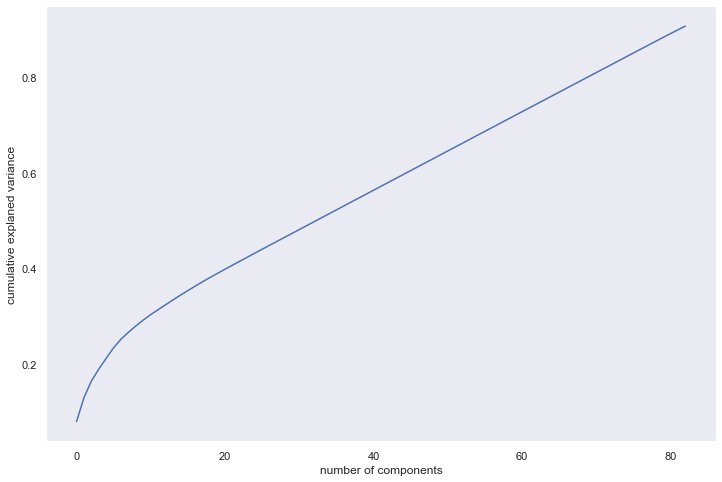

In [207]:
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explaned variance')
plt.show()

In [208]:
xTrainPca = pca.transform(xTrain)
xTestPca = pca.transform(xTest)

In [209]:
logUpdatePca = LogisticRegression(class_weight = 'balanced')
logUpdatePca.fit(xTrainPca, (y_Train))
predictions = logUpdatePca.predict(xTestPca)
probas = logUpdatePca.predict_proba(xTestPca)
print(classification_report(y_Test, predictions))
print(confusion_matrix(y_Test, predictions))
print("ACC -> ", accuracy_score(y_Test, predictions))
print("AUC -> ", metrics.roc_auc_score(y_Test, probas[:, 1]))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     20147
           1       0.98      0.99      0.98     17645

    accuracy                           0.99     37792
   macro avg       0.99      0.99      0.99     37792
weighted avg       0.99      0.99      0.99     37792

[[19800   347]
 [  190 17455]]
ACC ->  0.9857906435224386
AUC ->  0.9976362457951624


In [210]:
rfc = RandomForestClassifier(random_state = 4, verbose =  1)
rfc.fit(xTrainPca, y_Train)
predictions = rfc.predict(xTestPca)
probas = rfc.predict_proba(xTestPca)

print(classification_report(y_Test, predictions))
print(confusion_matrix(y_Test, predictions))
print("ACC -> ", accuracy_score(y_Test, predictions))
print("AUC -> ", metrics.roc_auc_score(y_Test, probas[:, 1]))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20147
           1       1.00      1.00      1.00     17645

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792

[[20127    20]
 [   40 17605]]
ACC ->  0.9984123624047417
AUC ->  0.9999163206257189


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [211]:
rfc = RandomForestClassifier(random_state=4, verbose=1)
rfc.fit(xTrain,y_Train)
predictions = rfc.predict(xTest)
probas=rfc.predict_proba(xTest)
print(classification_report(y_Test,predictions))
print(confusion_matrix(y_Test,predictions))
print("ACC ->", accuracy_score(y_Test,predictions)) 

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20147
           1       1.00      1.00      1.00     17645

    accuracy                           1.00     37792
   macro avg       1.00      1.00      1.00     37792
weighted avg       1.00      1.00      1.00     37792

[[20142     5]
 [   19 17626]]
ACC -> 0.9993649449618967


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


# Multinomial Classification

In [104]:
trainDF_Multi = trainDF_copy

In [105]:
trainDF_Multi.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attackType,last_flag,attack,attack_class,attack_display,attack_class_display
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.00,0.00,0.05,0.00,normal,20,0,0,normal,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.00,0.00,0.00,normal,15,0,0,normal,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,1.00,1.00,0.00,0.00,neptune,19,1,1,attack,dos
3,0,tcp,http,SF,232,8153,0,0,0,0,...,0.03,0.01,0.00,0.01,normal,21,0,0,normal,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,0.00,0.00,0.00,0.00,normal,21,0,0,normal,normal


In [106]:
trainDF_Multi = trainDF_Multi.drop(['attackType', 'attack', 'attack_display', 'attack_class_display']
                                  ,axis = 1)

In [107]:
trainDF_Multi.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag,attack_class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,20,0
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,15,0
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,19,1
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,21,0
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,21,0


In [109]:
trainDF_Multi = pd.get_dummies(trainDF_Multi)

In [110]:
x = trainDF_Multi.drop(['attack_class'], axis = 1)
y = trainDF_Multi['attack_class']

In [111]:
x_Train, xTest, y_Train, y_Test = train_test_split(x, y, test_size = 0.3, random_state = 4)
sc = StandardScaler()
xTrain = pd.DataFrame(sc.fit_transform(x_Train), columns = x.columns)
xTest = pd.DataFrame(sc.transform(x_Test), columns = x.columns)

## Logistic Regression Model with Recursive Feature Elim

In [112]:
logreg = LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg')
start = time.time()
rfe = RFE(logreg, 12)
rfe = rfe.fit(xTrain, y_Train)
print(rfe.support_)
print(rfe.ranking_)
print(time.time() - start,  'seconds to run')

[ True False False False  True False  True False False False False False
  True  True False False False  True  True False False False False False
 False False False False  True False  True False False False False False
 False False False  True  True False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False  True False False False
 False False]
[  1  34  43  64   1  96   1  44  14  22  32  93   1   1 100  57 111   1
   1   5   8   7  17  13  12  27  28  16   1   3   1  11  37   9  19  18
  23   6   2   1   1  66  81  55 108  67  75  54  46  45  61  76  68  33
  56  21  24  53  48  41  31  30  47 

In [113]:
cols_rfe = xTrain.columns[rfe.support_]
cols_rfe

Index(['duration', 'wrong_fragment', 'hot', 'num_root', 'num_file_creations',
       'is_guest_login', 'count', 'dst_host_srv_count',
       'dst_host_diff_srv_rate', 'protocol_type_tcp', 'protocol_type_udp',
       'flag_S0'],
      dtype='object')

In [114]:
logm1 = sm.GLM(list(y_Train), (sm.add_constant(xTrain[cols_rfe])))
print(logm1.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                88181
Model:                            GLM   Df Residuals:                    88168
Model Family:                Gaussian   Df Model:                           12
Link Function:               identity   Scale:                         0.21071
Method:                          IRLS   Log-Likelihood:                -56456.
Date:                Sun, 06 Dec 2020   Deviance:                       18578.
Time:                        20:05:23   Pearson chi2:                 1.86e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [120]:
cols_rfe = ['duration', 'wrong_fragment', 'hot', 'num_root',
           'num_file_creations', 'is_guest_login', 'count',
           'dst_host_srv_count', 'dst_host_diff_srv_rate', 'protocol_type_tcp',
           'protocol_type_udp', 'flag_S0']

logm2 = sm.GLM(list(y_Train), (sm.add_constant(xTrain[cols_rfe])))
logm2.fit().summary()
print(logm2.fit().summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                88181
Model:                            GLM   Df Residuals:                    88168
Model Family:                Gaussian   Df Model:                           12
Link Function:               identity   Scale:                         0.21071
Method:                          IRLS   Log-Likelihood:                -56456.
Date:                Sun, 06 Dec 2020   Deviance:                       18578.
Time:                        20:11:54   Pearson chi2:                 1.86e+04
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                      0

In [125]:
log_update = LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg',
                               class_weight = 'balanced')
log_update.fit(xTrain[cols_rfe], (y_Train))
predictions = log_update.predict(xTest[cols_rfe])
probas = log_update.predict_proba(xTest[cols_rfe])

print(classification_report(y_Test, predictions))
print(confusion_matrix(y_Test, predictions))

print("ACC -> ", accuracy_score(y_Test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.79      0.88     20147
           1       0.99      0.97      0.98     13851
           2       0.68      0.91      0.78      3470
           3       0.10      0.91      0.19       311
           4       0.01      0.46      0.02        13

    accuracy                           0.87     37792
   macro avg       0.55      0.81      0.57     37792
weighted avg       0.95      0.87      0.90     37792

[[16007   133  1302  2378   327]
 [  156 13447   160     2    86]
 [  136    17  3153    69    95]
 [    6     0     2   283    20]
 [    0     2     1     4     6]]
ACC ->  0.8704487722269263


##  Multinomial classification with PCA

83


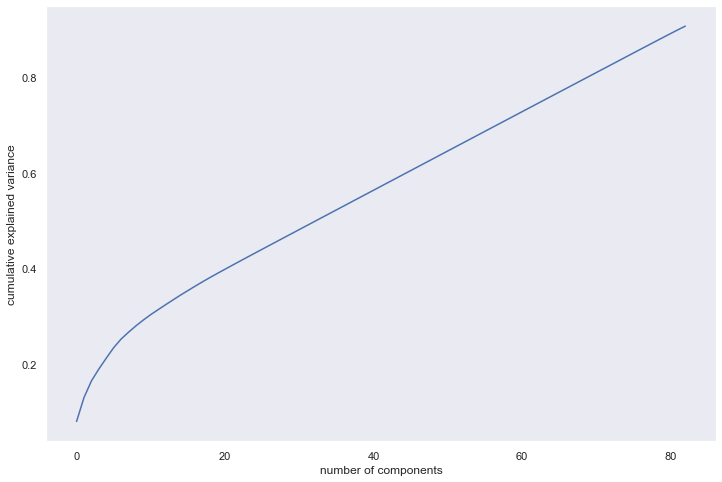

In [127]:
pca = PCA(0.90, random_state = 4)
pca.fit(xTrain)

print(pca.n_components_)
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [128]:
xTrainPca = pca.transform(xTrain)
xTestPca = pca.transform(xTest)

In [132]:
log_updatedPca = LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg',
                                  class_weight = 'balanced')
log_updatedPca.fit(xTrainPca, (y_Train))
predictions = log_updatedPca.predict(xTestPca)
probas = log_updatedPca.predict_proba(xTestPca)
print(classification_report(y_Test, predictions))
print(confusion_matrix(y_Test, predictions))
print("ACC -> ", accuracy_score(y_Test, predictions))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99     20147
           1       0.99      0.99      0.99     13851
           2       0.94      0.99      0.96      3470
           3       0.75      0.95      0.84       311
           4       0.20      0.69      0.31        13

    accuracy                           0.98     37792
   macro avg       0.77      0.92      0.82     37792
weighted avg       0.99      0.98      0.98     37792

[[19727   125   186    91    18]
 [   79 13751    18     1     2]
 [   29    11  3420     4     6]
 [    3     0     0   297    11]
 [    0     0     0     4     9]]
ACC ->  0.984441151566469


ValueError: multiclass format is not supported

In [133]:
rfc = RandomForestClassifier(class_weight = 'balanced', random_state = 4, verbose = 1)
rfc.fit(xTrainPca, y_Train)
predictions = rfc.predict(xTestPca)
probas = rfc.predict_proba(xTestPca)

print(classification_report(y_Test, predictions))
print(confusion_matrix(y_Test, predictions))
print("ACC -> ", accuracy_score(y_Test, predictions))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20147
           1       1.00      1.00      1.00     13851
           2       1.00      0.99      0.99      3470
           3       0.98      0.95      0.96       311
           4       0.67      0.46      0.55        13

    accuracy                           1.00     37792
   macro avg       0.93      0.88      0.90     37792
weighted avg       1.00      1.00      1.00     37792

[[20131     3     7     4     2]
 [    4 13847     0     0     0]
 [   21     9  3440     0     0]
 [   13     0     1   296     1]
 [    4     0     0     3     6]]
ACC ->  0.9980948348856901


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished


In [135]:
rfc = RandomForestClassifier(class_weight = 'balanced', random_state = 4, verbose =1 )
rfc.fit(xTrain, y_Train)
predictions = rfc.predict(xTest)
probas = rfc.predict_proba(xTest)
print(classification_report(y_Test, predictions))
print(confusion_matrix(y_Test, predictions))
print('ACC -> ', accuracy_score(y_Test, predictions))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     20147
           1       1.00      1.00      1.00     13851
           2       1.00      1.00      1.00      3470
           3       0.99      0.95      0.97       311
           4       0.89      0.62      0.73        13

    accuracy                           1.00     37792
   macro avg       0.97      0.91      0.94     37792
weighted avg       1.00      1.00      1.00     37792

[[20140     0     3     4     0]
 [    3 13848     0     0     0]
 [    5     0  3465     0     0]
 [   15     0     0   295     1]
 [    5     0     0     0     8]]
ACC ->  0.9990474174428451


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    0.0s finished
